In [1]:
from hydra.utils import instantiate
import yaml
import torch
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from giae.so2.data import MNISTDataModule, MNISTDataset
from torch.utils.data import Dataset, DataLoader
from giae.so2.trainer import Trainer
from torchvision.transforms import RandomRotation, Pad, Resize, ToTensor, GaussianBlur
from PIL import Image
import escnn
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [5]:
# or load model

import mlflow
from serotiny.ml_ops.mlflow_utils import download_artifact, load_model_from_checkpoint, _get_config

# b8eebf73d9054bcf8c7640368b29cd80 -  classical AEZ

model = load_model_from_checkpoint("https://mlflow.a100.int.allencell.org", "219be2a55c0b49c78cd9dbe24205a894", {})

/home/ritvik.vasan/.cache/pypoetry/virtualenvs/aics-latent-spaces-XUDj-riv-py3.9/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:213: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['encoder.image.block1.0.filter', 'encoder.image.block2.0.filter', 'encoder.image.block3.0.filter', 'encoder.image.block4.0.filter', 'encoder.image.block5.0.filter', 'encoder.image.block6.0.filter', 'encoder.image.block7.0.filter']
  rank_zero_warn(


In [6]:
device = "cuda:0"
model = model.to(device)
model = model.eval()

In [17]:
import pandas as pd
df1 = pd.read_csv('/allen/aics/modeling/bvae_analysis/data/cytodata/variance_2000.csv')

In [47]:
df_tmp = df1.loc[df1['CellId'] == 623094]

In [48]:
df_tmp.to_csv('/allen/aics/modeling/bvae_analysis/data/cytodata/variance_test.csv')

In [59]:
from hydra.utils import instantiate
import yaml

data = instantiate(yaml.full_load('''
  _target_: serotiny.datamodules.ManifestDatamodule
  path: /allen/aics/modeling/bvae_analysis/data/cytodata/variance_2000.csv
  batch_size: 16
  num_workers: 0
  loaders:
    image:
      _target_: serotiny.io.dataframe.loaders.LoadImage
      column: registered_path
      select_channels:
      - membrane_segmentation
      - dna_segmentation
      ome_zarr_level: 2
      unsqueeze_first_dim: false
      dtype: float32
      transform:
      - _target_: torchio.transforms.Resize
        target_shape: 28
    cell_id:
      _target_: serotiny.io.dataframe.loaders.LoadColumns
      contains: CellId
    class:
      _target_: serotiny.io.dataframe.loaders.LoadColumns
      contains: nbr_complete
  split_column: split
  columns: null
'''))

In [60]:
dl = next(iter(data.test_dataloader()))

import pytorch_lightning as pl
pl.seed_everything(42)

def rotate(matrix, deg_angle, axis):
    d = len(matrix)
    h = len(matrix[0])
    w = len(matrix[0][0])
    min_new_x = 0
    max_new_x = 0
    min_new_y = 0
    max_new_y = 0
    min_new_z = 0
    max_new_z = 0
    new_coords = []
    angle = radians(deg_angle)

    for z in range(d):
        for y in range(h):
            for x in range(w):

                new_x = None
                new_y = None
                new_z = None

                if axis == "x":
                    new_x = int(round(x))
                    new_y = int(round(y*cos(angle) - z*sin(angle)))
                    new_z = int(round(y*sin(angle) + z*cos(angle)))
                elif axis == "y":
                    new_x = int(round(z*sin(angle) + x*cos(angle)))
                    new_y = int(round(y))
                    new_z = int(round(z*cos(angle) - x*sin(angle)))
                elif axis == "z":
                    new_x = int(round(x*cos(angle) - y*sin(angle)))
                    new_y = int(round(x*sin(angle) + y*cos(angle)))
                    new_z = int(round(z))

                val = matrix.item((z, y, x))
                new_coords.append((val, new_x, new_y, new_z))
                if new_x < min_new_x: min_new_x = new_x
                if new_x > max_new_x: max_new_x = new_x
                if new_y < min_new_y: min_new_y = new_y
                if new_y > max_new_y: max_new_y = new_y
                if new_z < min_new_z: min_new_z = new_z
                if new_z > max_new_z: max_new_z = new_z

    new_x_offset = abs(min_new_x)
    new_y_offset = abs(min_new_y)
    new_z_offset = abs(min_new_z)

    new_width = abs(min_new_x - max_new_x)
    new_height = abs(min_new_y - max_new_y)
    new_depth = abs(min_new_z - max_new_z)

    rotated = np.empty((new_depth + 1, new_height + 1, new_width + 1))
    rotated.fill(0)
    for coord in new_coords:
        val = coord[0]
        x = coord[1]
        y = coord[2]
        z = coord[3]

        if rotated[new_z_offset + z][new_y_offset + y][new_x_offset + x] == 0:
            rotated[new_z_offset + z][new_y_offset + y][new_x_offset + x] = val

    matrix = rotated
    return matrix

Global seed set to 42


In [61]:
dl['cell_id'].shape

torch.Size([16, 1])

In [74]:
from math import radians, cos, sin
import torchio

x =  dl['image'][2]

# x =  dl['image'][0]
in_x_2 = x.cpu().numpy()


totensor = ToTensor()
size =28
resize = torchio.transforms.Resize(target_shape=28)

all_x_r = []
for channel in range(2):
    in_x = in_x_2[channel]
    x_r = np.concatenate((
        resize(np.expand_dims(rotate(in_x, 0*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 0.5*90, 'z'), axis=0)),
        resize(np.expand_dims(rotate(in_x, 1*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 1.5*90, 'z'), axis=0)),
        resize(np.expand_dims(rotate(in_x, 2*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 2.5*90, 'z'), axis=0)),
        resize(np.expand_dims(rotate(in_x, 3*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 3.5*90, 'z'), axis=0))
), axis=0)
    all_x_r.append(x_r)
all_x_r = np.stack(all_x_r, axis=1) 
all_x_r = torch.tensor(all_x_r)

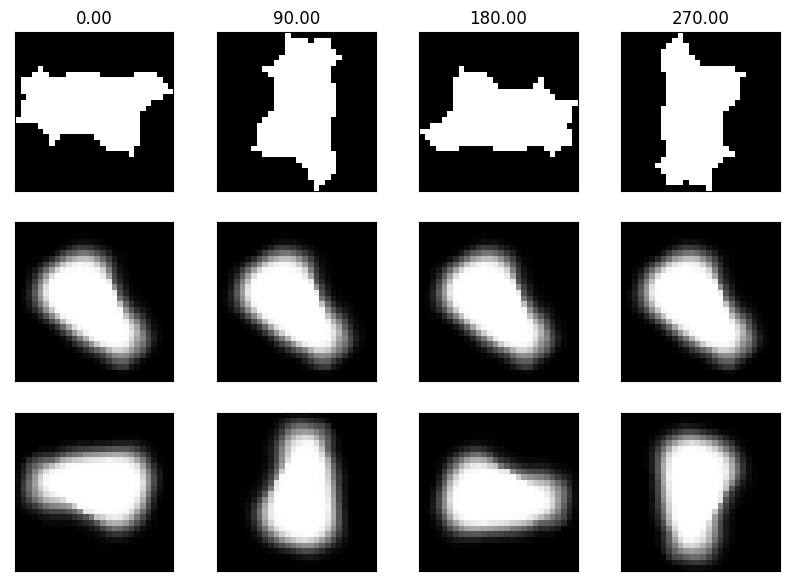

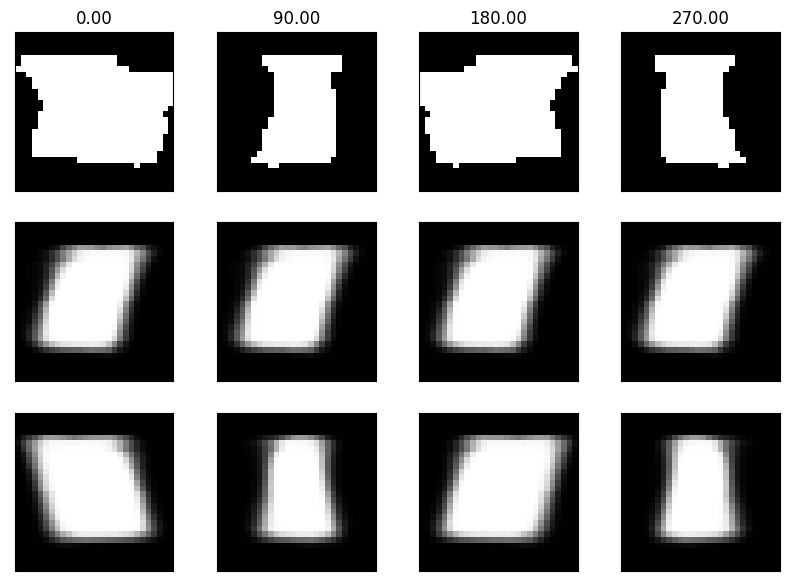

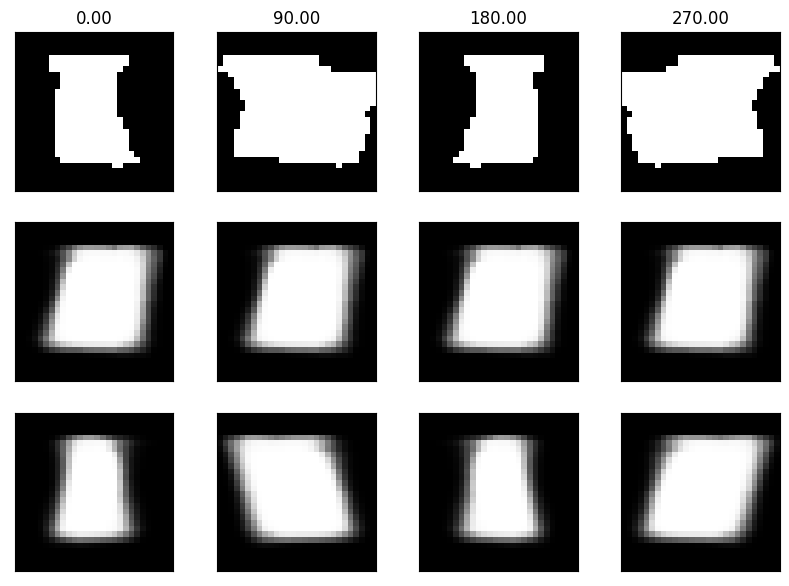

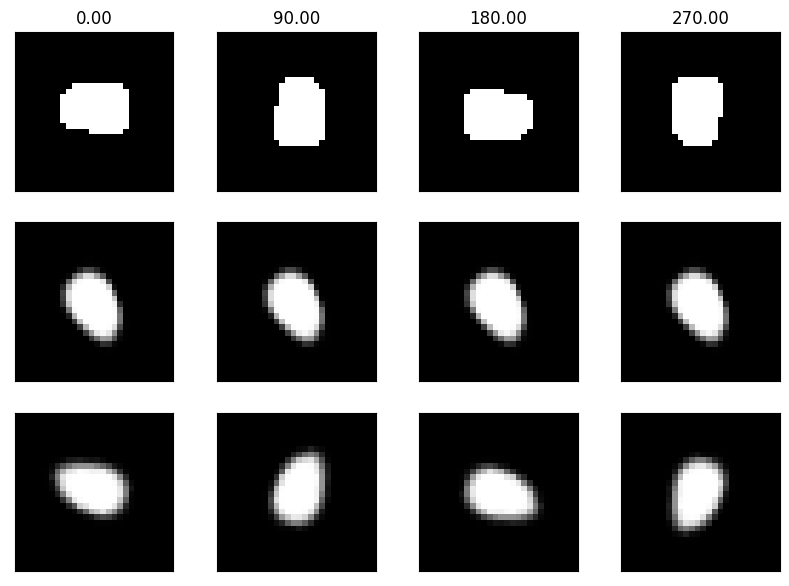

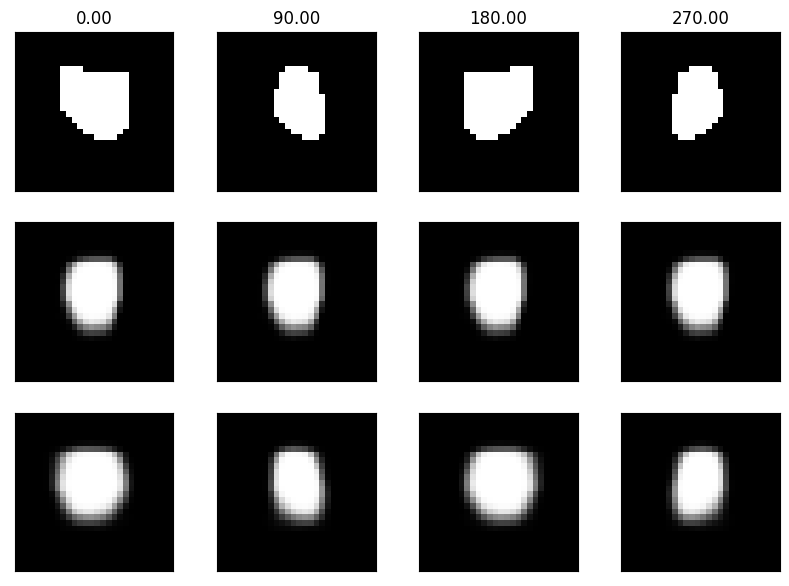

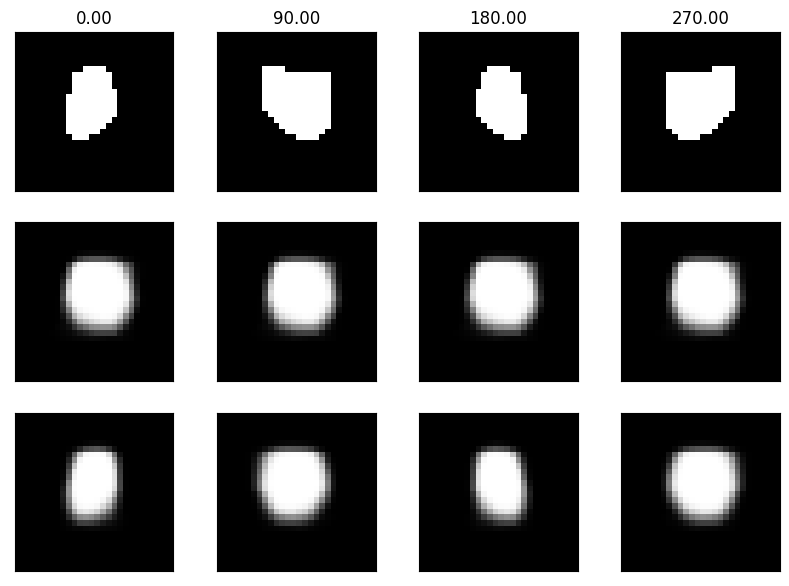

In [75]:

device = "cuda:0"
all_x_r = {'image': all_x_r.to(device)}

model.to(device)
with torch.no_grad():
    y, _, z_parts_params_1, _, _, _, _, _ = model(all_x_r, do_rot=False, decode=True, compute_loss=True)
    y2, _, z_parts_params_2, _, _, _, _, _  = model(all_x_r, do_rot=True, decode=True, compute_loss=True)
    y = y['image'].cpu().numpy()
    y2 = y2['image'].cpu().numpy()
    if 'angle' in z_parts_params_1.keys():
        rot_1 = z_parts_params_1['angle'].cpu().numpy()
        rot_2 = z_parts_params_2['angle'].cpu().numpy()


for proj in [0, 1]:
    for j in [0, 1, 2]:

        fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
#         theta = torch.Tensor([0, 0.5*90, 1*90, 1.5*90, 2*90, 2.5*90, 3*90, 3.5*90])
        theta = torch.Tensor([0,  1*90,  2*90, 3*90])
        for i in range(len(theta)):
            ax[0, i].imshow(all_x_r['image'][i][proj].max(j)[0].detach().cpu().numpy(), cmap="gray")
            ax[1, i].imshow(y[i][proj].max(j), cmap="gray")
            ax[2, i].imshow(y2[i][proj].max(j), cmap="gray")
            ax[0, i].set_title("%.2f" % (theta[i].numpy()))
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
        plt.show()

In [76]:
import numpy as np
from meshpy.tet import MeshInfo, build
import numpy as np
from ipygany import Scene, TetraMesh
import numpy as np
import mcubes


def export_mesh(img_in, filename):
    # Extract the 0-isosurface
    # vertices, triangles = mcubes.marching_cubes(img3,0.5)
    vertices, triangles = mcubes.marching_cubes(img_in,0.5)

    # Export the result to sphere.dae
    # mcubes.export_mesh(vertices, triangles, "sphere.dae", "MySphere")
    mcubes.export_obj(vertices, triangles, f'meshes/{filename}.obj')

    vert_list = []
    for i in range(vertices.shape[0]):
        vert_list.append(list(vertices[i]))
    triangles_list = []
    for i in range(triangles.shape[0]):
        triangles_list.append(list(triangles[i]))

    mesh_info = MeshInfo()
    mesh_info.set_points(vert_list)
    mesh_info.set_facets(triangles_list)
    mesh = build(mesh_info)

    # Normalize mesh for viz

    norm_verts = (vertices - vertices.mean(axis=0))/(vertices.std(axis=0))

    vert_list = []
    for i in range(vertices.shape[0]):
        vert_list.append([list(norm_verts[i])[2], list(norm_verts[i])[1], list(norm_verts[i])[0]])
    triangles_list = []
    for i in range(triangles.shape[0]):
        triangles_list.append(list(triangles[i]))
    vertices_norm = np.stack(vert_list, axis=0)
    mcubes.export_obj(vertices_norm, triangles, f'meshes/{filename}_norm.obj')

In [77]:
all_x_r['image'].shape

torch.Size([4, 2, 28, 28, 28])

In [78]:
# ind = 3
ind = 3
img_in = all_x_r['image'][ind][0].detach().cpu().numpy()
img_recon = y[ind][0]
img_recon2 = y2[ind][0]

In [79]:
export_mesh(img_in, 'input')
export_mesh(img_recon, 'recon_inv')
export_mesh(img_recon2, 'recon')

In [80]:
for ind in range(4):
    for channel in range(2):
        img_in = all_x_r['image'][ind][channel].detach().cpu().numpy()
        img_recon = y[ind][channel]
        img_recon2 = y2[ind][channel]
        export_mesh(img_in, f'input_chan_{channel}_rot_{ind}')
        export_mesh(img_recon, f'recon_inv_chan_{channel}_rot_{ind}')
        export_mesh(img_recon2, f'recon_chan_{channel}_rot_{ind}')

2022-11-28 00:00:01,591	WARNING worker.py:1829 -- The log monitor on node prd-aics-dcp-038 failed with the following error:
Traceback (most recent call last):
  File "/home/ritvik.vasan/.cache/pypoetry/virtualenvs/aics-latent-spaces-XUDj-riv-py3.9/lib/python3.9/site-packages/ray/_private/log_monitor.py", line 520, in <module>
    log_monitor.run()
  File "/home/ritvik.vasan/.cache/pypoetry/virtualenvs/aics-latent-spaces-XUDj-riv-py3.9/lib/python3.9/site-packages/ray/_private/log_monitor.py", line 436, in run
    anything_published = self.check_log_files_and_publish_updates()
  File "/home/ritvik.vasan/.cache/pypoetry/virtualenvs/aics-latent-spaces-XUDj-riv-py3.9/lib/python3.9/site-packages/ray/_private/log_monitor.py", line 339, in check_log_files_and_publish_updates
    file_info.reopen_if_necessary()
  File "/home/ritvik.vasan/.cache/pypoetry/virtualenvs/aics-latent-spaces-XUDj-riv-py3.9/lib/python3.9/site-packages/ray/_private/log_monitor.py", line 79, in reopen_if_necessary
    new